## Before starting: select "dtw" kernel

- In the menu bar on top of this notebook, select Kernel > Change Kernel > "dtw"

- In the top right corner, there should be the Python logo and "dtw" should be written next to the circle monitoring kernel activity.


# (Step2) Align two sequences with `sm-dtw`

*In step1*, you previously produced a pair of phyllotaxis sequences: one reference sequence and a test sequence which derives from the first after typical "measurement errors". Each phyllotaxis sequence is made of two sub-sequences: the divergence angles and the internode lengths between successive organs along a stem.

Here, you will use our program `sm-dtw` to realign the test sequence with the reference and detect automatically the potential additions or losses of organs along the test sequence.


## Upload simulated sequences generated in step1

In [1]:
import numpy as np
import pandas as pd

from dtw import DTW
from dtw.metrics import angular_dist
from dtw.metrics import euclidean_dist
from dtw.metrics import mixed_dist
from dtw.tasks.search_free_ends import brute_force_free_ends_search

In [2]:
ref_df = pd.read_csv("/myapp/docker_sandbox/reference_sequences.csv")
test_df = pd.read_csv("/myapp/docker_sandbox/test_sequences.csv")

In [3]:
# have a look at the table
# check out the PlantID: there should be only one after step1 notebook, default is "MyPlant"
ref_df
# test_df

,PlantID,angles,Internodes
0,MyPlant,147,60
1,MyPlant,150,29
2,MyPlant,151,13
3,MyPlant,160,11
4,MyPlant,127,14
5,MyPlant,166,11
6,MyPlant,99,10
7,MyPlant,162,11
8,MyPlant,131,1
9,MyPlant,159,5


In [4]:
# Create ground-truth & predicted angles and inter-nodes arrays
# Change the PlantID if needed
plant_id = "MyPlant"
seq_ref = np.array([ref_df[ref_df["PlantID"] == plant_id]["angles"],
                            ref_df[ref_df["PlantID"] == plant_id]["Internodes"]]).T
seq_test = np.array([test_df[test_df["PlantID"] == plant_id]["angles"],
                             test_df[test_df["PlantID"] == plant_id]["Internodes"]]).T

## Initialize the DTW object
To performs this alignment, we use the **"merge-split" constraint** to account for organ under or over segmentation.
We also use a **"mixed distance"** reflecting that among the two component of the phyllotaxis, the divergence angles are circular values whereas internode lengths are scalar values

In [5]:
# Variables associated to 'mixed-distance':
    # during realignment, the parameter 'ldist' selects a function to compute the local distance used to compare values of both sequences.
    # ldist can take three possible values: `euclidean_dist()` (default),  `angular_dist()` or `mixed_dist()`
mtype = [True, False] # (mixed_type): a boolean vector, of size ``n_dim``, indicating whether the k^th component should be treated as an angle (``True``) or a regular scalar value (``False``)
max_ref = np.max(seq_ref[:, 1])
max_test = np.max(seq_test[:, 1])
mspread = [1, max(max_ref, max_test)] # (mixed_spread): a vector of positive scalars, of size ``n_dim``, used to normalize the distance values computed for each component with their typical spread
mweight = [0.5, 0.5] # (mixed weight): weigths attributed to angles and internodes, respectively (positive weights. they do not necessarily sum to 1, but normalized if not)

# naming
seq_names=["Angles", "Internodes"]

## Run a first realignment for phyllotaxis sequences
This first realignment assumes that the start and the end of the paired sequences matches ("**bounded ends**"): in other terms, segmentation errors are excluded from the first and last organs.

In [12]:
dtwcomputer = DTW(seq_test, seq_ref, 
                  constraint='merge_split',dist_type="mixed",
                  mixed_type=mtype, mixed_spread=mspread, mixed_weight=mweight,
                  names=seq_names)
#: List of valid values for `dist_type` parameter.
# DIST_TYPES = {"euclidean", "angular", "mixed"}

************************************ INFOS *************************************
Test sequence length: 20
ference sequence length: 19
Type of constraints: symmetric
Beam size:  None
Free endings: (0, 1)
*********************************** RESULTS ************************************
Alignment:
test seq:  [117   0] [338  95] [174   3] [165   8] [132  10] [156   8] [88 14] [149  15] [126   1] [155   1] [304   2] [195   9] [115   1] [130   0] [90  1] [30  4] [175  10] [136   1]  - s[21  9] [86  4] 
ref seq :  [147  60] [150  29] [151  13] [160  11] [127  14] [166  11] [99 10] [162  11] [131   1] [159   5]  -  [139   4] [119   6]  -  [118  10] [121   6] [180   6] [145   4] [142   6] [143  12] [136   5] 
Optimal path length: 21
Optimal normalized cost: 42.21022578296128 at cell (19, 18) (non normalized: 886.4147414421869
Array of global distances (x downward, y rightward):
 [[  67.082  111.014      inf      inf      inf      inf      inf      inf
       inf      inf      inf      inf      i

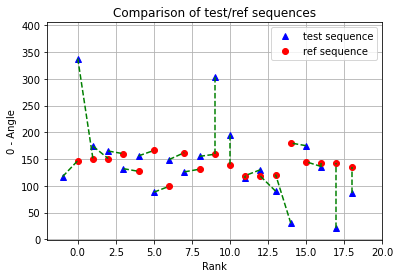

-----> minh, maxh= -2 0
score array= [26. 15. 16.]
 shift =  -1


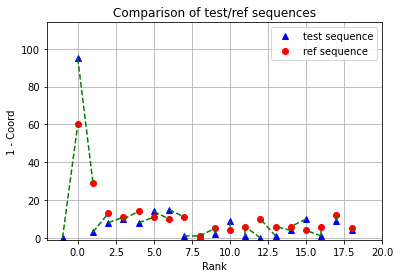

,test,reference,type,cost
0,0,0,s,67.082039
1,1,1,s,199.248588
2,2,2,s,25.079872
3,3,3,s,5.830952
4,4,4,s,6.403124
5,5,5,s,10.440307
6,6,6,s,11.704700
7,7,7,s,13.601471
8,8,8,s,5.000000
9,9,9,s,5.656854


In [13]:
# Print the results with a graphic visusalisation of the alignment
dtwcomputer.run()
dtwcomputer.print_results(graphic_seq_alignment=True)

#Interpret the graphic:
# dotted green lines are matching corresponding intervals:
# one-to-one match (one triangle to one dot): no segmentation issue, possible shifts
# several triangles to one one point: merge events (over-segmentation, some organs were added in the test sequence within a previous ref interval)
# several points to one triangle: split event (under-segmentation, some organs were missed in the test sequence)

## Testing manually different free-ends
Let's realign the sequence by allowing another value for free-ends. Note that this will not impose that ending intervals are trimmed, but the program will explore this possibility.

The solution may be different, but in that case, the associated normalized cost will also evolves.

In the program, free-ends are specified with a tuple of 2 integers ``(k,l)`` that specifies relaxation bounds on the alignment of sequences endpoints: relaxed by ``k`` at the sequence beginning and relaxed by ``l`` at the sequence ending. (k,l) must verify these two conditions:
        
        - ``k + l < min(N_test, N_ref)``
        - ``k >= 0`` and ``l >= 1``


In [ ]:
# check the previous values of free-ends: default -and minimum value- is (0,1) for perfectly matching start and end sequences.
dtwcomputer.free_ends #check the current value

In [ ]:
dtwcomputer.free_ends = (5, 5) #impose a new value
dtwcomputer.run()
dtwcomputer.print_results(graphic_seq_alignment=True)

## Automatic selection of free-ends
`sm-dtw` can automatize the search of an optimal free-ends size: the program will look for possible relaxation bounds at both ends and compute the normalized cost for each of them. It then select the best free-ends solution based on the evolution of the normalised cost: this one reaches a plateau after this point. The main parameter to select here is `free_ends_eps`: it determines the minimum difference to previous minimum normalized cost to consider tested free-ends as the new best combination (ie *"the lower, the easier to increase free-ends"*)

Note however that **free-ends trimming is limited to max 40%** of the shortest sequence length among the pair to avoid overfitting of extremely short and costless alignment solutions.

In [ ]:
free_ends, n_cost = brute_force_free_ends_search(dtwcomputer, free_ends_eps=0.001)
print(f"Found free-ends {free_ends} with a normalized distance of {n_cost}.")

## Export results in a table for Step3 (assessment of sm-dtw prediction)

In [ ]:
dtwcomputer.free_ends = free_ends #up-date free-ends value with the automatic selection
dtwcomputer.run() #re-run the alignment with the new free-ends parameter and minimal printed infos/flags
df = dtwcomputer.print_results() #store the results
# reformat the table for compatibility (later in Step3)
df.insert(loc=0, column='PlantID', value=[plant_id] * len(df_result.index))
df.to_csv('/myapp/docker_sandbox/smdtw_result.csv', index = False) #the result is in 'the docker_sandbox' folder as a csv file called "smdtw_result.csv"

In [ ]:
print(df)

## End of Step2